# ARIMA GARCH
___

In the hrv_arima notebook, I ran through the steps for deducing the appropriate paramters for an ARIMA model. Because it was my first attempt as well a discursive in order to explain it to the reader (myself), I fleshed out much of the discussion as well as cutting the analysis down to keep things simple. I also ignored most of the data available to me and worked with only a few variables which I have little reason to think are particularly suitable for ARIMA testing. Another thing that bugged me was the arbitrary choice of season and it made no sense to me that there wouldn't be tests for it. So, for this notebook, I want to repeat the steps of the initial arima notebook but with a few changes.

1. Incorporate all of the available data
2. Simplify and generalise things
3. Plot relevant outputs
4. Do a GARCH to introduce forecasting of variance

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import json

### Some questions 

Q: How do I get seasonality?

FFT. Numpy has a convenient, discrete FFT function built into it. 

**Steps**

1. Separate scores and metrics. In particular, datetimes converted into integers should probably be treated differently.
2. For each unique set, infer seasonality using FFT
3. Infer other ARIMA parameters
4. Introduce GARCH to the most "successful" model


In [2]:
# --- Grab data 

data = pd.read_csv("data/oura_clean.csv")
data.index = pd.to_datetime(data['date'])
data = data.drop(["Unnamed: 0",'date'], axis=1)
data = data[[i for i in data.columns if "score" not in i]]
columns = data.columns
display(data.head())

# --- Store SARIMAX parameters
sarimax_params = {}

,total_bedtime,total_sleep_time,awake_time,rem_sleep_time,light_sleep_time,deep_sleep_time,restless_sleep,sleep_efficiency,sleep_latency,sleep_timing,...,steps,daily_movement,inactive_time,rest_time,low_activity_time,medium_activity_time,high_activity_time,non_wear_time,average_met,long_periods_of_inactivity
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,31380.0,25440.0,5940.0,4530.0,14760.0,6150.0,39.0,81.0,690.0,14550.0,...,10182,8158,433,528,135,71,0,273,1.40625,0
2020-01-02,31680.0,25200.0,6480.0,3900.0,15270.0,6030.0,37.0,80.0,960.0,15390.0,...,11540,9193,549,531,289,57,0,14,1.50000,0
2020-01-03,28980.0,23010.0,5970.0,720.0,16500.0,5790.0,40.0,79.0,780.0,14400.0,...,12361,10451,404,473,202,84,2,275,1.50000,0
2020-01-04,28140.0,23280.0,4860.0,4620.0,14460.0,4200.0,44.0,83.0,900.0,14490.0,...,18978,16275,329,501,484,73,0,53,1.71875,0
2020-01-05,30300.0,23460.0,6840.0,2100.0,13170.0,8190.0,34.0,77.0,1680.0,14610.0,...,11761,9867,359,530,298,47,0,206,1.46875,0


In [3]:
columns

Index(['total_bedtime', 'total_sleep_time', 'awake_time', 'rem_sleep_time',
       'light_sleep_time', 'deep_sleep_time', 'restless_sleep',
       'sleep_efficiency', 'sleep_latency', 'sleep_timing', 'bedtime_start',
       'bedtime_end', 'average_resting_heart_rate',
       'lowest_resting_heart_rate', 'average_hrv',
       'temperature_deviation_celcius', 'respiratory_rate', 'activity_burn',
       'total_burn', 'target_calories', 'steps', 'daily_movement',
       'inactive_time', 'rest_time', 'low_activity_time',
       'medium_activity_time', 'high_activity_time', 'non_wear_time',
       'average_met', 'long_periods_of_inactivity'],
      dtype='object')

In [4]:
data['bedtime_start']

date
2020-01-01    1577790038
2020-01-02    1577876522
2020-01-03    1577962103
2020-01-04    1578048994
2020-01-05    1578137012
                 ...    
2021-01-23    1611315377
2021-01-24    1611401789
2021-01-25    1611488201
2021-01-26    1611574741
2021-01-27    1611660624
Name: bedtime_start, Length: 392, dtype: int64

## Determine d for SARIMAX(p, d, q)

In [5]:
# --- Attain d: Augmented Dicky Fuller Testing

from statsmodels.tsa.stattools import adfuller

def make_stationary(
    col : pd.core.series.Series,
    verbose : bool=False,
    significance : float=0.05) -> (int, pd.core.series.Series):

    has_root = True # "H0: series has a unit root"
    d = 0 # n differencing required
    x = col
    while has_root:
        result =  dict(zip(['adf', 'pvalue', 'usedlag', 'nobs',
                             'critical' 'values', 'icbest'], adfuller(x)))
        if verbose: print(json.dumps(result, sort_keys=True, indent=4))
        if result['pvalue'] < significance: has_root = False
        else:
            x = x - x.shift(1)
            x = x.dropna()
            d += 1
    return d, x

In [6]:
# --- Build stationary df

stationary_df = pd.DataFrame(index=data.index, columns=data.columns)
sig = 0.01

for col in columns:
    stationarity = make_stationary(data[col], significance=sig, verbose=False)
    sarimax_params[col] = {"d" : stationarity[0]}
    stationary_df[col] = stationarity[1]

In [7]:
# # --- Determine seasonality

# var = 'temperature_deviation_celcius'
# test = stationary_df[var]
# N = len(test)

# ft = np.fft.fft(test) / N
# ft = ft[range(int(N/2))]

# _, ax = plt.subplots(len(columns), 2, figsize=(18, 4 * len(columns)))
# for i in range(len(columns)):
#     col_data = stationary_df[columns[i]]
#     ax[i, 0].set_title(f'test variable: {columns[i]} original plot')
#     ax[i, 0].plot(range(N), col_data)

# #     ft = np.fft.fft(col_data, norm="ortho")# / N
# #     ft = ft[range(int(N/2))]
# #     v = np.arange(N/2)
# #     freq = v/(N/len(col_data))
    
# #     t = np.arange(256)
#     sp = np.fft.fft(col_data)
#     freq = np.fft.fftfreq(np.arange(N).shape[-1])
#     ax[i, 1].plot(freq, sp.real, freq, sp.imag, "--")
    
# #     ax[i, 1].plot(freq[1:25], abs(ft)[1:25])

## Determine p for SARIMAX(p, d, q)

0 0


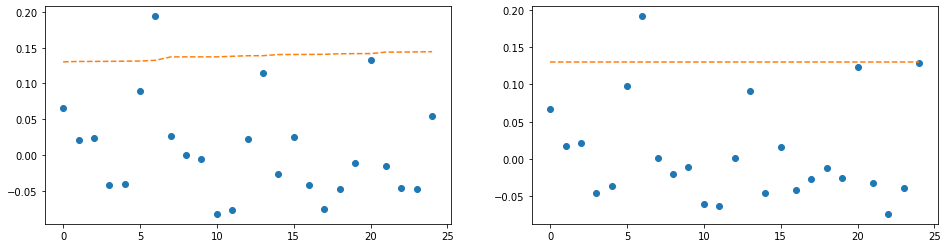

In [8]:
# --- Attain p : Autocorrelation

from statsmodels.tsa.stattools import acf, pacf

_, ax = plt.subplots(1, 2, figsize=(16, 4))

# var = 'average_hrv'
var = 'sleep_timing'

test = stationary_df[var]
N = len(test)
nlags = int(10 * np.log10(N))

acf_x, acf_conf = acf(test, alpha=sig, nlags=nlags, fft=False)
pacf_x, pacf_conf = pacf(test, alpha=sig, nlags=nlags)

# remove zero lag
acf_x, pacf_x = acf_x[1:], pacf_x[1:] 
acf_conf, pacf_conf = acf_conf[1:], pacf_conf[1:]

sig_acf_count, sig_pacf_count = 0, 0
pacf_above = True
acf_above = True

while acf_above:
    if 2 * acf_x[sig_acf_count] - acf_conf[sig_acf_count, 1] > 0.01:
        sig_acf_count += 1
    else:
        acf_above = False
        
while pacf_above:
    if 2 * pacf_x[sig_pacf_count] - pacf_conf[sig_pacf_count, 1] > 0.01:
        sig_pacf_count += 1
    else:
        pacf_above = False

print(sig_acf_count, sig_pacf_count)

ax[0].plot(range(nlags), acf_x, 'o')
ax[0].plot(range(nlags), acf_conf[:, 1] - acf_x,'--')

ax[1].plot(range(nlags), pacf_x, 'o')
ax[1].plot(range(nlags), pacf_conf[:, 1] - pacf_x, '--')

In [9]:
# --- Attain p, q

from statsmodels.tsa.stattools import acf, pacf

def autocorr_tests(
    col : pd.core.series.Series,
    plot : bool=False,
    significance : float=0.05) -> (int, int):
    
    N = len(col)
    nlags = int(10 * np.log10(N))
    
    acf_x, acf_conf = acf(col, alpha=sig, nlags=nlags, fft=False)
    pacf_x, pacf_conf = pacf(col, alpha=sig, nlags=nlags)

    # remove zero lag
    acf_x, pacf_x = acf_x[1:], pacf_x[1:]
    acf_conf, pacf_conf = acf_conf[1:], pacf_conf[1:]

    sig_acf_count, sig_pacf_count = 0, 0
    pacf_above = True
    acf_above = True
    
    while acf_above:
        if 2 * acf_x[sig_acf_count] - acf_conf[sig_acf_count, 1] > 0.01:
            sig_acf_count += 1
        else:
            acf_above = False

    while pacf_above:
        if 2 * pacf_x[sig_pacf_count] - pacf_conf[sig_pacf_count, 1] > 0.01:
            sig_pacf_count += 1
        else:
            pacf_above = False
    
    if plot:
        _, ax = plt.subplots(1, 2, figsize=(16, 4))
        ax[0].plot(range(nlags), acf_x, 'o')
        ax[0].plot(range(nlags), acf_conf[:, 1] - acf_x,'--')
        ax[1].plot(range(nlags), pacf_x, 'o')
        ax[1].plot(range(nlags), pacf_conf[:, 1] - pacf_x, '--')
        ax[0].set(ylim=(-1, 1))
        ax[1].set(ylim=(-1, 1))
    return (sig_acf_count, sig_pacf_count)

In [10]:
for i in columns:
    
    counts = autocorr_tests(stationary_df[i])
    print(i, counts)

total_bedtime (0, 0)
total_sleep_time (0, 0)
awake_time (2, 2)
rem_sleep_time (0, 0)
light_sleep_time (1, 1)
deep_sleep_time (1, 1)
restless_sleep (2, 1)
sleep_efficiency (4, 2)
sleep_latency (0, 0)
sleep_timing (0, 0)
bedtime_start (0, 0)
bedtime_end (0, 0)
average_resting_heart_rate (10, 5)
lowest_resting_heart_rate (10, 5)
average_hrv (10, 4)
temperature_deviation_celcius (1, 1)
respiratory_rate (6, 2)
activity_burn (3, 1)
total_burn (1, 1)
target_calories (5, 3)
steps (4, 1)
daily_movement (4, 3)
inactive_time (0, 0)
rest_time (0, 0)
low_activity_time (2, 2)
medium_activity_time (4, 1)
high_activity_time (0, 0)
non_wear_time (0, 0)
average_met (3, 2)
long_periods_of_inactivity (1, 1)


(6, 2)

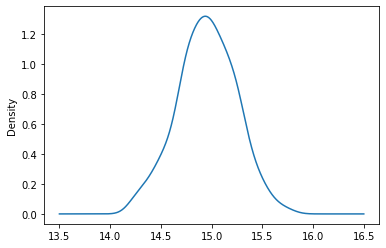

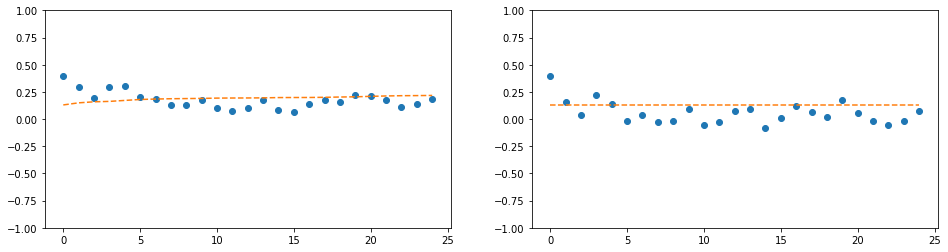

In [11]:
test_v = "respiratory_rate"
stationary_df[test_v].plot(kind="kde")
autocorr_tests(stationary_df[test_v], plot=True)

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


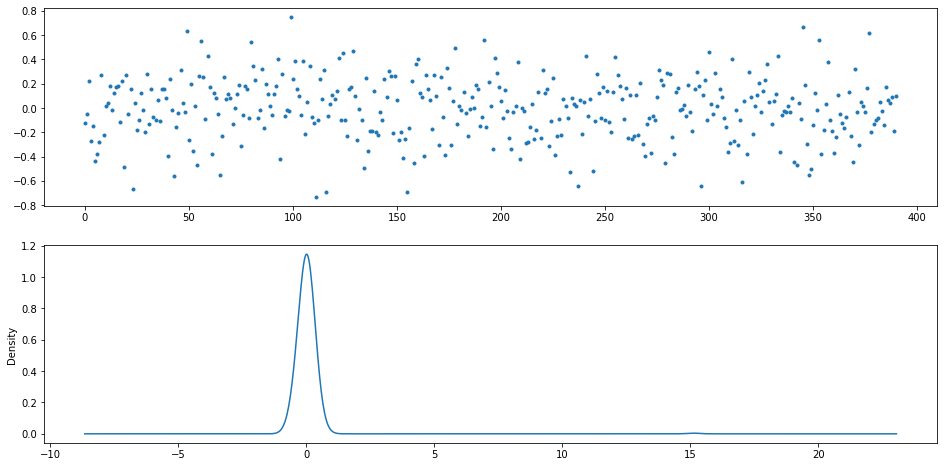

In [37]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# d : differencing
# p : AR terms
# q : MA terms

p, d, q = 6, 1, 2

model = SARIMAX(
        stationary_df[test_v],
        order=(p, d, q),
    );

_, ax = plt.subplots(2, 1, figsize=(16, 8))

fit = model.fit();
residuals = fit.resid;

y = stationary_df[test_v]
x = len(y)-1
# ax.plot(range(x), y[1:]-np.mean(y[1:]))
ax[0].plot(range(x), residuals[1:], '.')

model.fit().resid.plot(kind="kde", ax=ax[1])
ax[1].set();

ar.L1    -0.067607
ar.L2     0.185224
ar.L3    -0.045886
ar.L4     0.122784
ar.L5     0.167206
ar.L6    -0.008901
ma.L1    -0.636385
ma.L2    -0.323244
sigma2    0.063760
dtype: float64


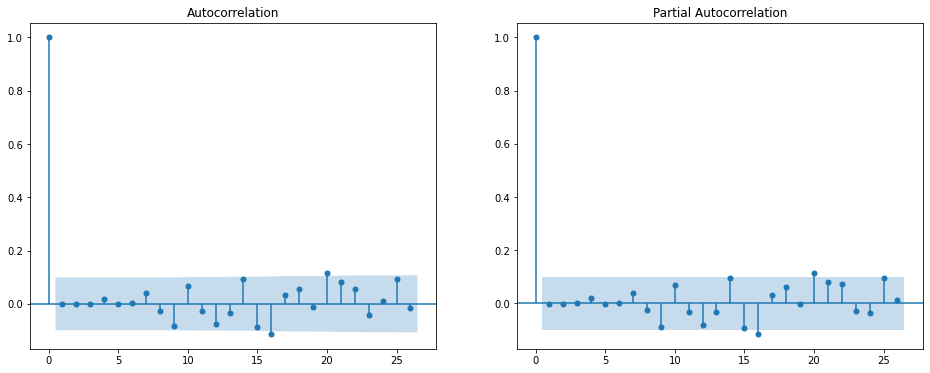

In [38]:
print(fit.params)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

_, ax = plt.subplots(1, 2, figsize=(16, 6))

plot_acf(residuals[1:], ax=ax[0], );
plot_pacf(residuals[1:], ax=ax[1]);

<AxesSubplot:xlabel='date'>

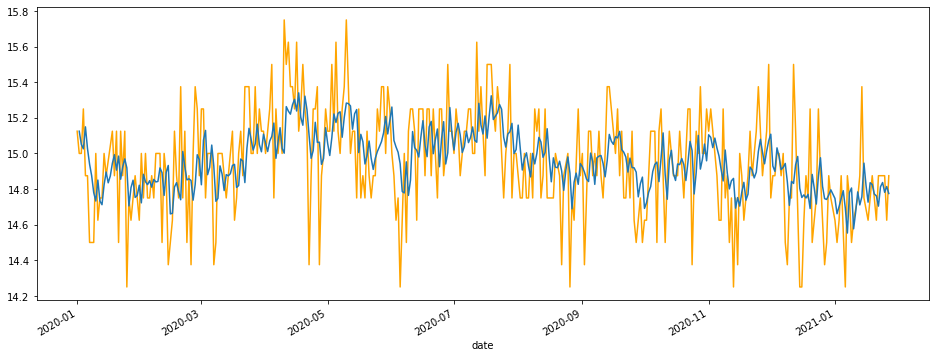

In [39]:
_, ax = plt.subplots(1, figsize=(16, 6))
stationary_df[test_v].plot(ax=ax, c="orange")
model_ = fit.predict()[1:]
model_.plot(ax=ax)


In [15]:
ar, ma, sig = fit.params

pred_y = [stationary_df[test_v][0]]

for t in range(x):
    y_next = - ar * pred_y[t] - 

SyntaxError: invalid syntax (<ipython-input-15-1e0f904649f4>, line 6)

In [ ]:
m2 = model.clone(stationary_df[test_v])
new_parameters = 
m2.update(new_parameters)


In [ ]:
dates = stationary_df.index
n=10
extended = dates.union(dates.shift(periods=n, freq="D")[-n:])



In [ ]:
# ((residuals - np.mean(residuals))/np.std(residuals)).plot(kind='kde')
np.mean(residuals), np.std(residuals)

In [ ]:
np.std(residuals)

In [ ]:
from scipy.stats import shapiro

n_stat, p_val = shapiro(residuals)
print(p_val)

In [ ]:
var = 'total_sleep_time'
test = stationary_df[var]
x = acf(test, alpha=0.01, fft=False)
xfft = acf(test, alpha=0.01, fft=True)

x_ax = range(len(x[0]))

_, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].plot(x_ax, x[1][:, 1] - x[0])
ax[0].plot(x_ax, x[0], 'x', c="orange" )


ax[1].plot(x_ax, xfft[1][:, 1] - x[0])
ax[1].plot(x_ax, xfft[0], 'x', c="orange" )